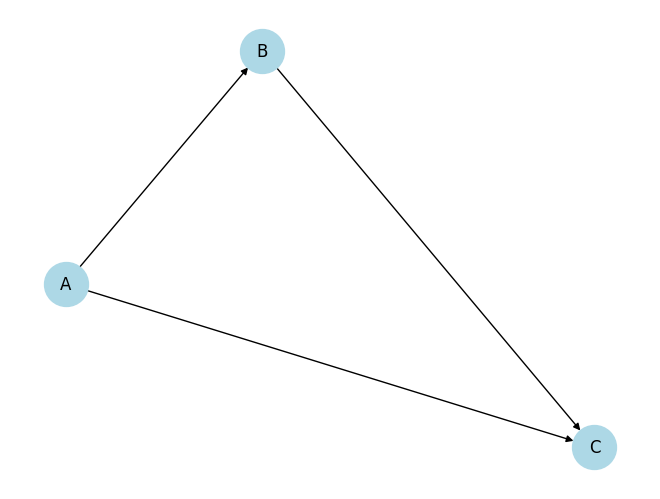

In [7]:
from dag import DAG
from node import Node
import json

# Load DAG from JSON file
def load_dag_from_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    dag = DAG()
    for node_info in data['nodes']:
        node = Node(node_info['id'], node_info.get('label'))
        dag.add_node(node)
    for edge in data['edges']:
        dag.add_edge(edge[0], edge[1])
    return dag

# Visualize DAG from JSON
json_path = 'graphs/dag_1.json'
dag = load_dag_from_json(json_path)
dag.visualize()